# Lasso regression on old dataset

In [162]:
library(caret)
library(glmnet)
library(doMC)

Loading required package: lattice



The `clean_cancer_old.csv` dataset contains all the 16235 cancer cells. However, the number of genes is reduced to 14297. This is done by eliminating all columns with NaNs.  

In [8]:
rna_old <- read.csv(file = '/data/severs/clean_cancer_old.csv')

In [13]:
rownames(rna_old) <- rna_old$X

In [14]:
rna_old$X <- NULL

In [18]:
Y = rna_old$ESR1
X = rna_old[, -match("ESR1", colnames(rna_old))]

In [78]:
rsq <- function (x, y) cor(x, y) ^ 2
rmse <- function (x, y) sqrt(mean((x-y)^2))

The split is stratified on the expression of ESR1. However, this can be performed on patient level as well.

In [208]:
set.seed(2)
train.index <- createDataPartition(Y, p = .8, list = FALSE)

In [214]:
X_train <- X[train.index,]

In [211]:
Y_train <- Y[train.index]

In [215]:
X_test <- X[-train.index,]

In [213]:
Y_test <- Y[-train.index]

The input is normalized (subtract mean, divide by std) on the training data which is used to normalize the test data.

In [216]:
normParam <- preProcess(X_train)

In [217]:
norm.X_train <- predict(normParam, X_train)

In [218]:
norm.X_test <- predict(normParam, X_test)

In [318]:
lambdas <- 10^seq (-0.5, -3, by = -.05)

In [220]:
registerDoMC(cores = 20)

In [255]:
set.seed(2)
cv_lasso  <- cv.glmnet(as.matrix(norm.X_train) , Y_train,
                       nfolds = 5, alpha = 1, lambda = lambdas,
                       type.measure = "deviance", parallel=TRUE)

In [307]:
prediction <- predict(cv_lasso, newx=as.matrix(norm.X_test))

In [308]:
pred <- data.frame(list(prediction, Y_test))

In [309]:
colnames(pred) <- c("prediction", "truth")

In [310]:
pred <- pred[order(pred$truth),]

In [311]:
r2score <- rsq(Y_test, prediction)
rmsescore <- rmse(Y_test, prediction)

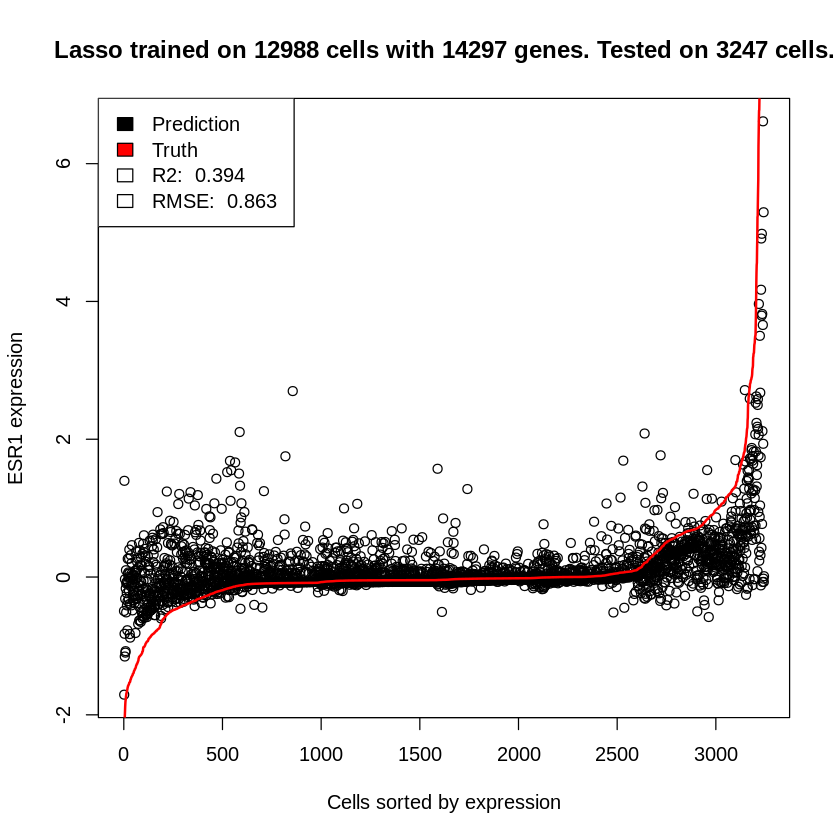

In [312]:
plot(pred$prediction, pch=1, ylab="ESR1 expression", xlab="Cells sorted by expression")
lines(pred$truth, col="red", lw=2)
legend("topleft", 
       legend=c("Prediction", "Truth",
                paste("R2: ", substr(toString(r2score), 1, 5)),
                paste("RMSE: ", substr(toString(rmsescore), 1, 5))),
       fill=c("black","red", "white", "white"))
title("Lasso trained on 12988 cells with 14297 genes. Tested on 3247 cells.")

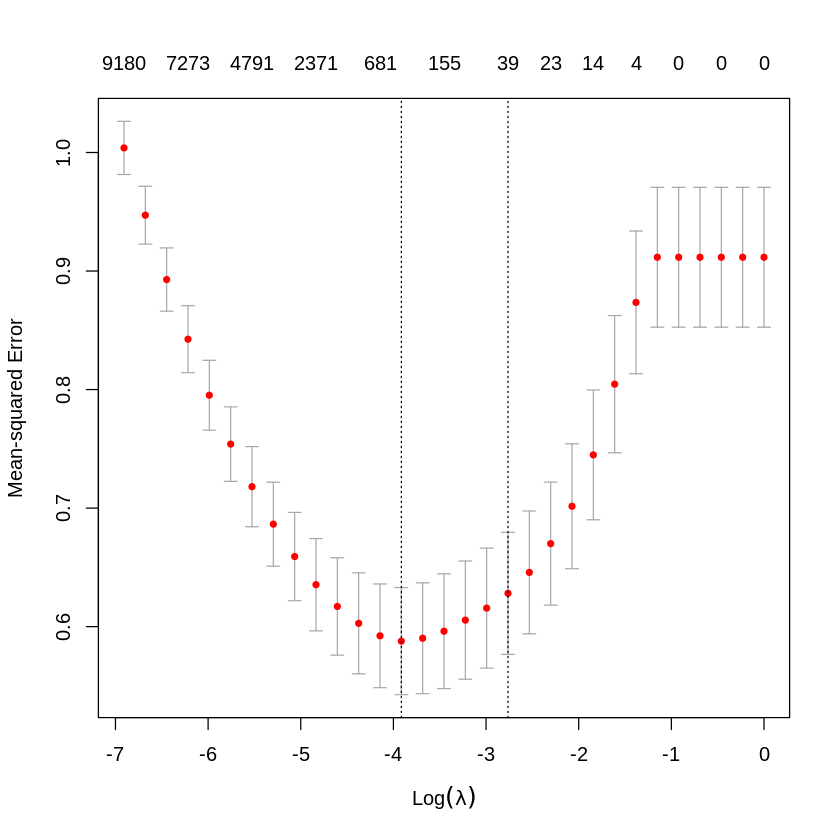

In [314]:
plot(cv_lasso)

In [52]:
cv_lasso$lambda.1se/sum(abs(coef(cv_lasso)))
cv_lasso$lambda.min/sum(abs(coef(cv_lasso, s=cv_lasso$lambda.min)))

[1] 0.04386434

[1] 0.006422705

In [54]:
lasso.mod <- glmnet(X_train, Y_train, alpha=1,  parallel=TRUE)

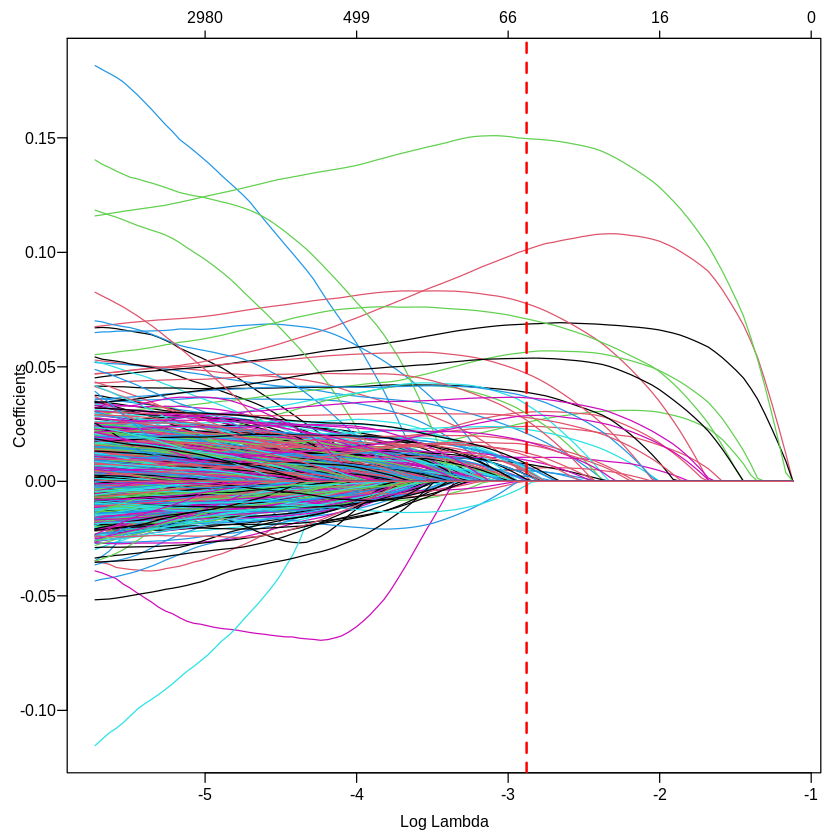

In [64]:
par(mfrow = c(1,1), mar = c(3.5,3.5,2,1), mgp = c(2, 0.6, 0), cex = 0.8, las = 1)
plot(lasso.mod, xvar="lambda")
abline(v=log(cv_lasso$lambda.1se), col="red", lw=2, lty=2)

In [437]:
biggest <- match(max(abs(coef(cv_lasso)[2:length(coef(cv_lasso))])),as.numeric(coef(cv_lasso)))

## Stratification on patient level with differentially expressed data

In [66]:
load("/data/xiaoral/rna_metadata.Rdata")

In [67]:
rownames(metadata.df) <- metadata.df$Cell

In [68]:
metadata.df$Cell <- NULL

In [104]:
set.seed(42)
train.index2 <- createDataPartition(metadata.df[metadata.df$CellType=="Cancer", ]$PatientNumber[abs(Y)>0.5], p = .8, list = FALSE)

In [105]:
X_train2 <- X[abs(Y)>0.5,][train.index2,]
Y_train2 <- Y[abs(Y)>0.5][train.index2]

In [106]:
X_test2 <- X[abs(Y)>0.5,][-train.index2,]
Y_test2 <- Y[abs(Y)>0.5][-train.index2]

In [107]:
# Scaling

normParam2 <- preProcess(X_train2)
X_train2 <- predict(normParam2, X_train2)
X_test2 <- predict(normParam2, X_test2)

In [108]:
lambdas2 <- 10^seq (0, -2.5, by = -.05)

In [109]:
set.seed(42)
cv_lasso2  <- cv.glmnet(as.matrix(X_train2) , Y_train2, nfolds = 5, alpha = 1, lambda = lambdas2 , type.measure = "deviance", parallel=TRUE)

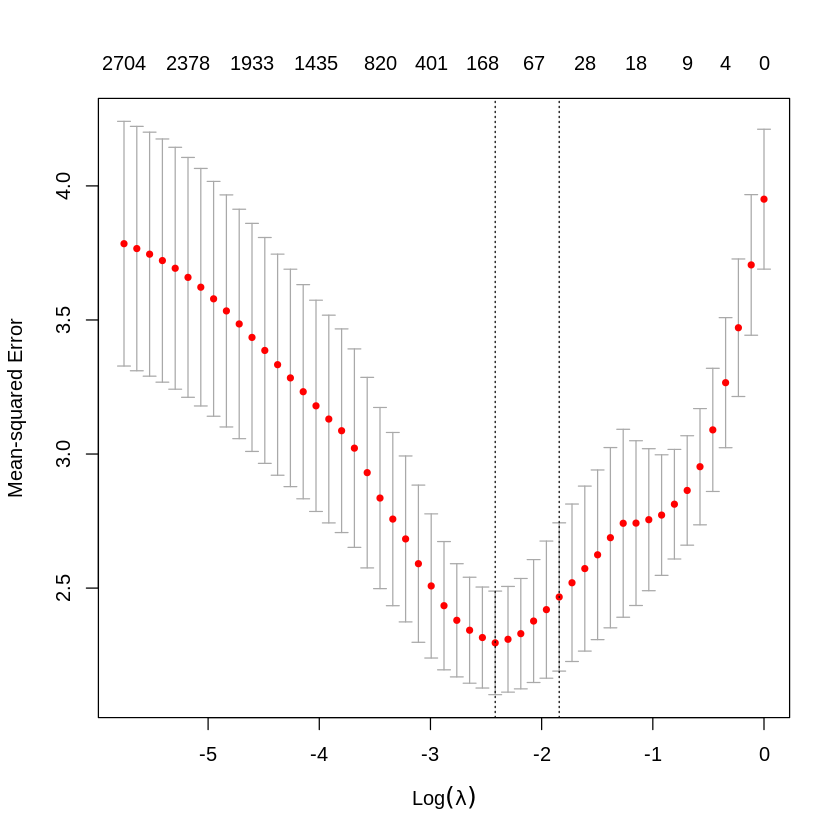

In [110]:
plot(cv_lasso2)

In [162]:
# Test on testset
prediction <- predict(cv_lasso2, newx=as.matrix(X_test2))
pred <- data.frame(list(prediction, Y_test2))
colnames(pred) <- c("prediction", "truth")
pred <- pred[order(pred$truth),]
r2score <- rsq(Y_test2, prediction)
rmsescore <- rmse(Y_test2, prediction)

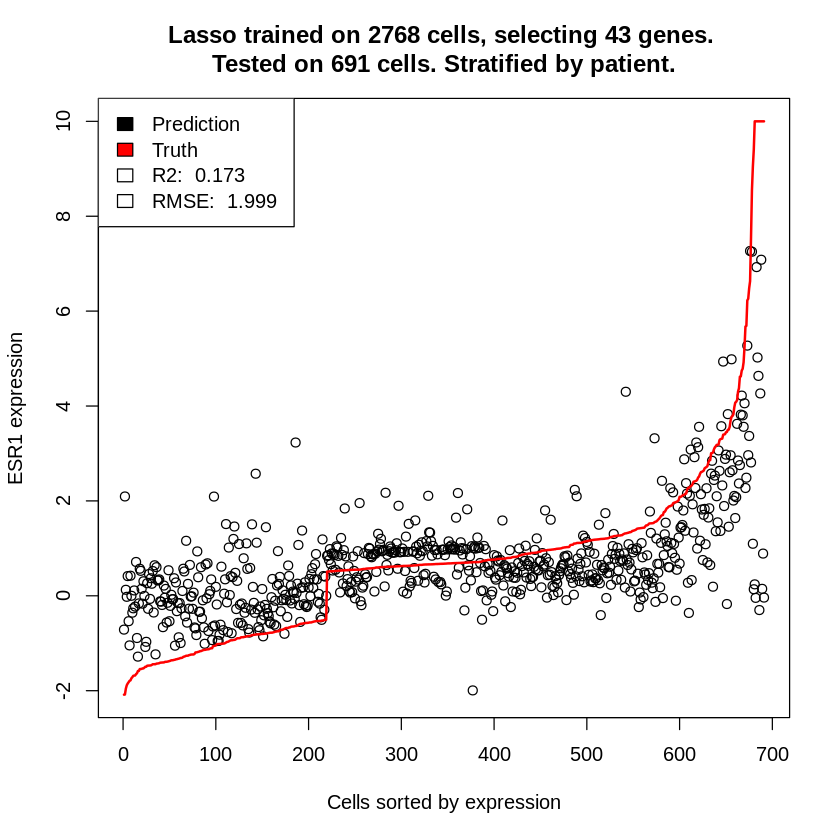

In [163]:
plot(pred$prediction, pch=1, ylab="ESR1 expression", xlab="Cells sorted by expression",
     ylim=c(min(c(1, min(pred$truth))), max(c(max(pred$prediction), max(pred$truth)))))
lines(pred$truth, col="red", lw=2)
legend("topleft", 
       legend=c("Prediction", "Truth",
                paste("R2: ", substr(toString(r2score), 1, 5)),
                paste("RMSE: ", substr(toString(rmsescore), 1, 5))),
       fill=c("black","red", "white", "white"))
title("Lasso trained on 2768 cells, selecting 43 genes. \nTested on 691 cells. Stratified by patient.")

In [113]:
"Number of genes"
sum(abs(coef(cv_lasso2, s = "lambda.1se"))>0)

[1] "Number of genes"

[1] 43

## Stratification on patient level with all data

In [130]:
set.seed(2)
train.index3 <- createDataPartition(metadata.df[metadata.df$CellType=="Cancer", ]$PatientNumber, p = .8, list = FALSE)

In [131]:
X_train3 <- X[train.index3,]
Y_train3 <- Y[train.index3]

In [132]:
X_test3 <- X[-train.index3,]
Y_test3 <- Y[-train.index3]

In [133]:
# Scaling

normParam3 <- preProcess(X_train3)
X_train3 <- predict(normParam2, X_train3)
X_test3 <- predict(normParam2, X_test3)

In [119]:
lambdas3 <- 10^seq (0.5, -3, by = -.05)

In [120]:
set.seed(2)
cv_lasso3  <- cv.glmnet(as.matrix(X_train3) , Y_train3,
                        nfolds = 5, alpha = 1, lambda = lambdas3 ,
                        type.measure = "deviance", parallel=TRUE)

In [121]:
sum(abs(coef(cv_lasso3))>0)

[1] 59

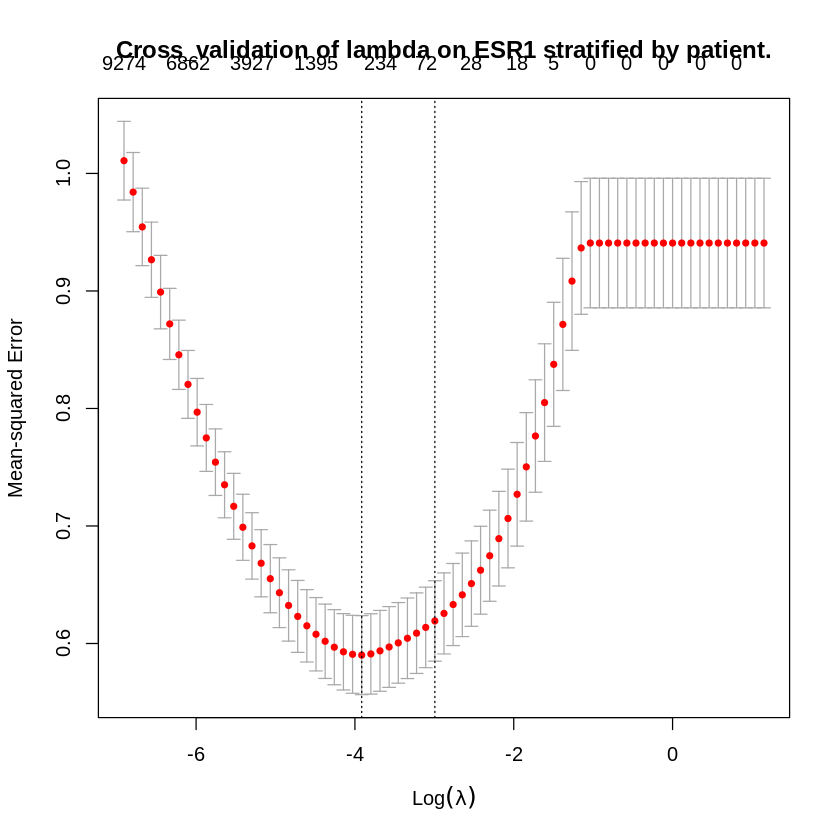

In [122]:
plot(cv_lasso3)
title("Cross_validation of lambda on ESR1 stratified by patient.")

In [123]:
# Test on testset
prediction <- predict(cv_lasso3, newx=as.matrix(X_test3))
pred <- data.frame(list(prediction, Y_test3))
colnames(pred) <- c("prediction", "truth")
pred <- pred[order(pred$truth),]
r2score <- rsq(Y_test3, prediction)
rmsescore <- rmse(Y_test3, prediction)

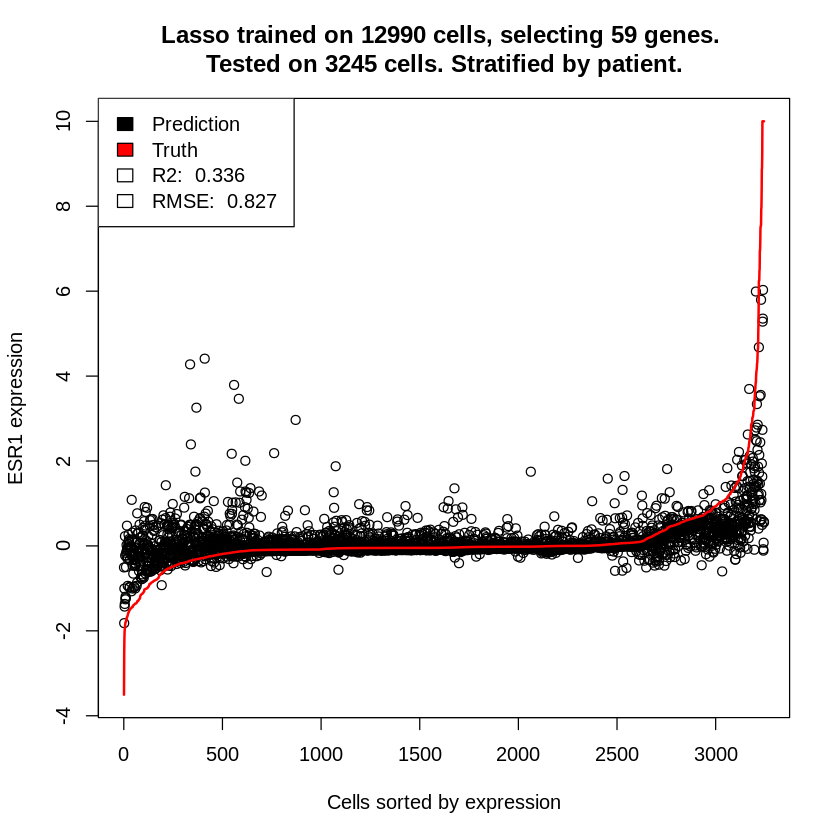

In [124]:
#pdf("/home/severs/SingleCells/plots/lasso_patient_strat.pdf")
plot(pred$prediction, pch=1, ylab="ESR1 expression", xlab="Cells sorted by expression",
     ylim=c(min(c(min(pred$prediction), min(pred$truth))), max(c(max(pred$prediction), max(pred$truth)))))
lines(pred$truth, col="red", lw=2)
legend("topleft", 
       legend=c("Prediction", "Truth",
                paste("R2: ", substr(toString(r2score), 1, 5)),
                paste("RMSE: ", substr(toString(rmsescore), 1, 5))),
       fill=c("black","red", "white", "white"))
title("Lasso trained on 12990 cells, selecting 59 genes. \nTested on 3245 cells. Stratified by patient.")
#dev.off()

The results of stratification on patients and stratification on ESR1 are very similar and it seems like there is no effect. 
Stratification on patients and stratification on ESR1 are `cv_lasso3` and `cv_lasso` respectively.

# XGBoost 

Below XGBoost tree models are used on the two previous datasets. We see that on the full dataset, Lasso and XGBoost perform about the same, but on the subset with differentially expressed cells XGboost is a lot better than Lasso. 

XGBoost achieves an RMSE of 1.03 and R2 of 0.718 while Lasso has 1.999 and 0.173 respectively. These results are from the test set.

On the full dataset stratified by patient XGBoost and Lasso performs about the same. 

Keep in mind that the results for XGBoost are not cross validated and simply trained on one set and tested on another. Lasso achieved MSE at around 2.5 -> RMSE=1.58 in cross validation. There is no cross-validation procedure for XGBoost in R and I'll either implement one myself or do more rigorous testing in Python. 

In [126]:
library(xgboost)

## XGBoost on full dataset stratified by patient

In [161]:
set.seed(2)
xgb3 <- xgboost(data = as.matrix(X_train3), 
 label = Y_train3, 
 eta = 0.05,
 max_depth = 6, 
 nround=200, 
 subsample = 0.8,
 colsample_bytree = 0.8,
 eval_metric = "rmse",
 objective = "reg:squarederror",
 nthread = 40, 
 verbose=0
)

In [164]:
# Test on testset
prediction <- predict(xgb3, newdata=as.matrix(X_test3))
pred <- data.frame(list(prediction, Y_test3))
colnames(pred) <- c("prediction", "truth")
pred <- pred[order(pred$truth),]
r2score <- rsq(Y_test3, prediction)
rmsescore <- rmse(Y_test3, prediction)

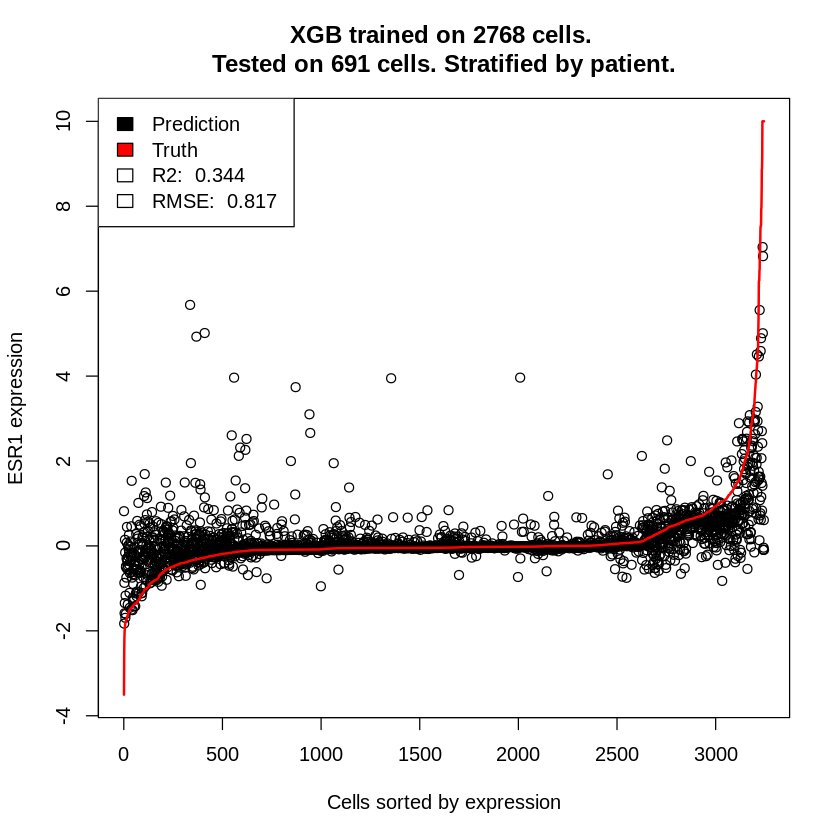

In [165]:
#pdf("/home/severs/SingleCells/plots/xgb_patient_strat.pdf")
plot(pred$prediction, pch=1, ylab="ESR1 expression", xlab="Cells sorted by expression",
     ylim=c(min(c(min(pred$prediction), min(pred$truth))), max(c(max(pred$prediction), max(pred$truth)))))
lines(pred$truth, col="red", lw=2)
legend("topleft", 
       legend=c("Prediction", "Truth",
                paste("R2: ", substr(toString(r2score), 1, 5)),
                paste("RMSE: ", substr(toString(rmsescore), 1, 5))),
       fill=c("black","red", "white", "white"))
title("XGB trained on 2768 cells. \nTested on 691 cells. Stratified by patient.")
#dev.off()

## XGBoost on differentially expressed subset stratified by patient 

In [157]:
set.seed(2)
xgb2 <- xgboost(data = as.matrix(X_train2), 
 label = Y_train2, 
 eta = 0.05,
 max_depth = 6, 
 nround=200, 
 subsample = 0.8,
 colsample_bytree = 0.8,
 eval_metric = "rmse",
 objective = "reg:squarederror",
 nthread = 40
)

[1]	train-rmse:1.937102 
[2]	train-rmse:1.870875 
[3]	train-rmse:1.806119 
[4]	train-rmse:1.744140 
[5]	train-rmse:1.688958 
[6]	train-rmse:1.633843 
[7]	train-rmse:1.583749 
[8]	train-rmse:1.536040 
[9]	train-rmse:1.491176 
[10]	train-rmse:1.444896 
[11]	train-rmse:1.400917 
[12]	train-rmse:1.358083 
[13]	train-rmse:1.317996 
[14]	train-rmse:1.281907 
[15]	train-rmse:1.245204 
[16]	train-rmse:1.212599 
[17]	train-rmse:1.182039 
[18]	train-rmse:1.152241 
[19]	train-rmse:1.120453 
[20]	train-rmse:1.092622 
[21]	train-rmse:1.064708 
[22]	train-rmse:1.040289 
[23]	train-rmse:1.015280 
[24]	train-rmse:0.993789 
[25]	train-rmse:0.974415 
[26]	train-rmse:0.955486 
[27]	train-rmse:0.936504 
[28]	train-rmse:0.917329 
[29]	train-rmse:0.897735 
[30]	train-rmse:0.883124 
[31]	train-rmse:0.866459 
[32]	train-rmse:0.851370 
[33]	train-rmse:0.837493 
[34]	train-rmse:0.822154 
[35]	train-rmse:0.809657 
[36]	train-rmse:0.796624 
[37]	train-rmse:0.784621 
[38]	train-rmse:0.772441 
[39]	train-rmse:0.760

In [158]:
# Test on testset
prediction <- predict(xgb2, newdata=as.matrix(X_test2))
pred <- data.frame(list(prediction, Y_test2))
colnames(pred) <- c("prediction", "truth")
pred <- pred[order(pred$truth),]
r2score <- rsq(Y_test2, prediction)
rmsescore <- rmse(Y_test2, prediction)

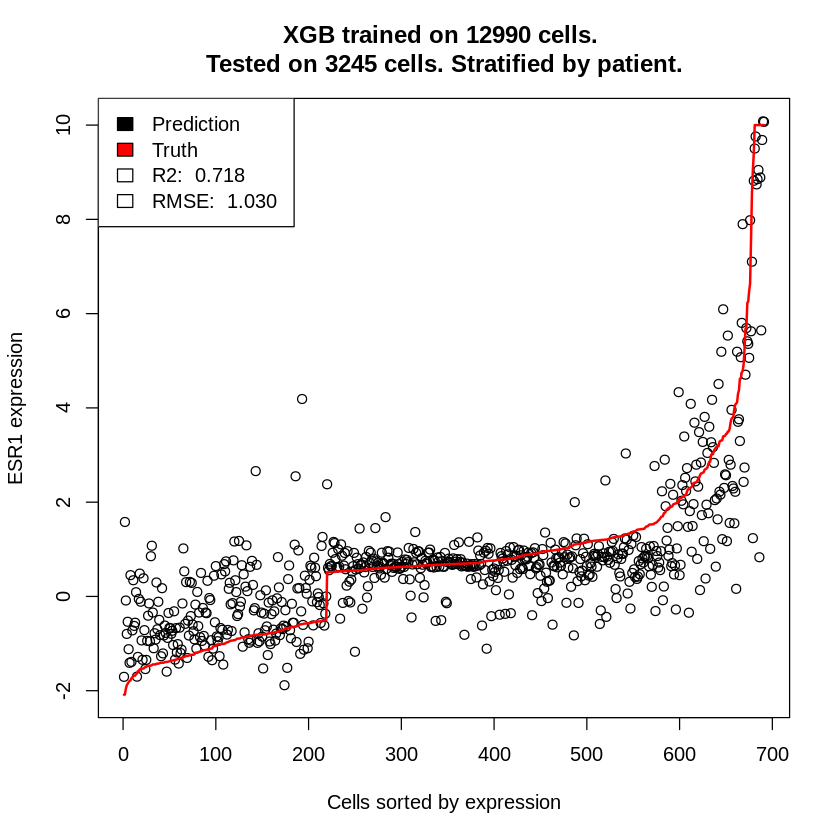

In [159]:
#pdf("/home/severs/SingleCells/plots/xgb_patient_strat.pdf")
plot(pred$prediction, pch=1, ylab="ESR1 expression", xlab="Cells sorted by expression",
     ylim=c(min(c(min(pred$prediction), min(pred$truth))), max(c(max(pred$prediction), max(pred$truth)))))
lines(pred$truth, col="red", lw=2)
legend("topleft", 
       legend=c("Prediction", "Truth",
                paste("R2: ", substr(toString(r2score), 1, 5)),
                paste("RMSE: ", substr(toString(rmsescore), 1, 5))),
       fill=c("black","red", "white", "white"))
title("XGB trained on 12990 cells. \nTested on 3245 cells. Stratified by patient.")
#dev.off()

# Analysis of NeoLetExe metadata

In [3]:
library("Seurat")

In [4]:
load("/data/severs/NeoLetExe_five_triplets.RData")

In [88]:
library("ggplot2")

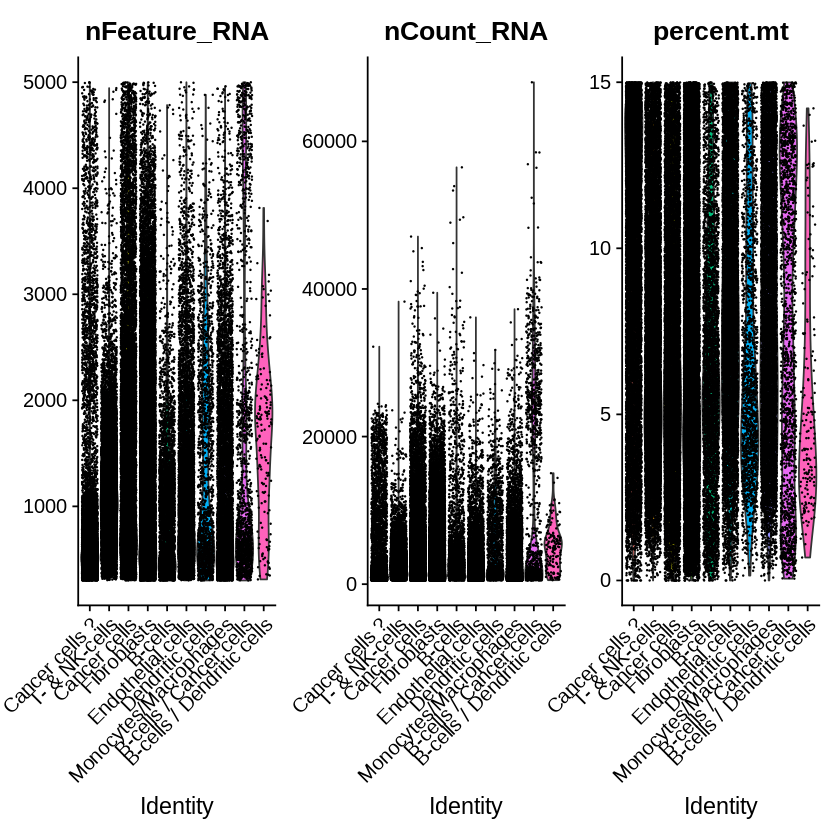

In [5]:
VlnPlot(Subset_Cells, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [6]:
Subset_Cells

An object of class Seurat 
33562 features across 94231 samples within 1 assay 
Active assay: RNA (33562 features, 0 variable features)
 2 dimensional reductions calculated: pca, umap

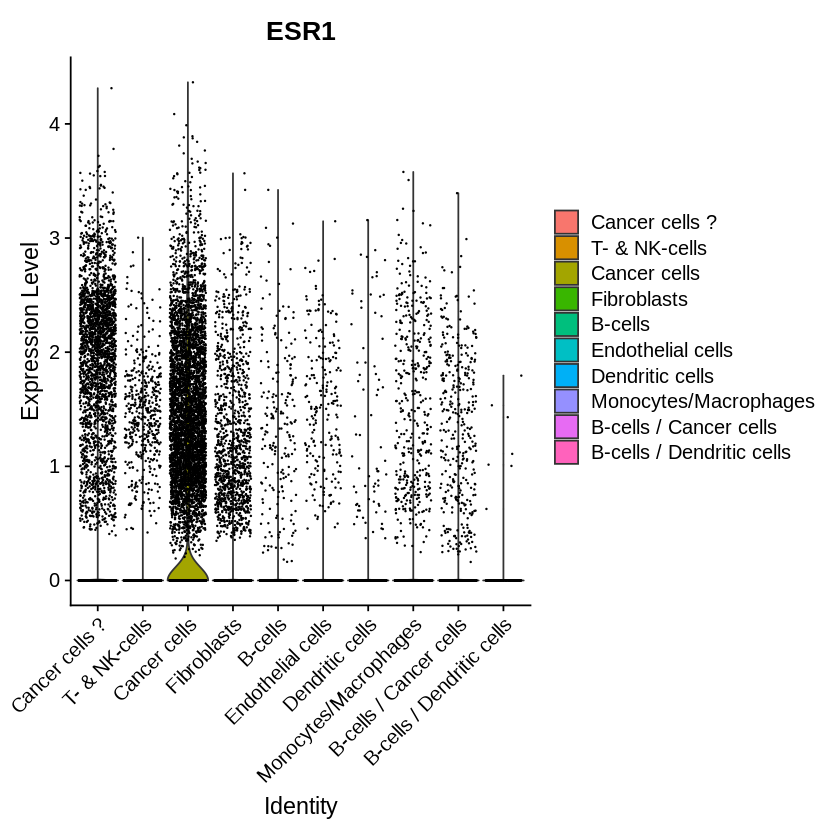

In [7]:
VlnPlot(object = Subset_Cells, features = c("ESR1"))

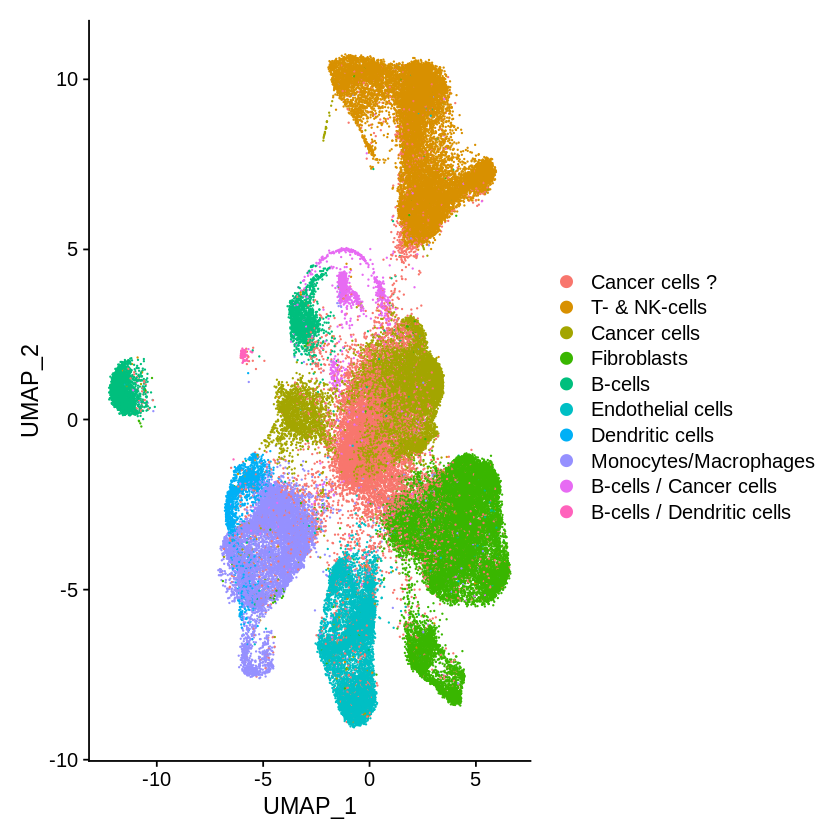

In [13]:
DimPlot(Subset_Cells)

In [6]:
meta_data <- data.frame(Subset_Cells@meta.data)

In [43]:

DimPlot(Subset_Cells, dims=c(1,2), reduction = "umap",label=TRUE)

#ggsave("/home/severs/SingleCells/plots/umap.png", height = 7 , width = 7 * 2)

ERROR: Error in value[[3L]](cond): could not open file '/tmp/RtmpfhtqBk/file8a3d78f412ff.png'


plot without title

In [10]:
UMAP_coord <- as.data.frame(Subset_Cells[["umap"]]@cell.embeddings)

In [11]:
UMAP_coord["patient_number"] <- meta_data["patient_number"]

In [12]:
meta_data["UMAP_1"] <- UMAP_coord["UMAP_1"]
meta_data["UMAP_2"] <- UMAP_coord["UMAP_2"]

In [15]:
write.csv(meta_data, "/data/severs/NeoLet_metadata.csv", row.names=TRUE)